**DATA PREPARATION**



*   Import Packages



In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math



*   Read data from a CSV file



In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VLO.csv')

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,92.190002,93.139999,91.709999,92.800003,72.733238,3582900
1,2018-01-03,92.580002,93.470001,92.500000,93.290001,73.117294,3057600
2,2018-01-04,93.410004,93.620003,92.639999,93.589996,73.352425,2977000
3,2018-01-05,93.599998,94.300003,93.430000,94.029999,73.697281,2973800
4,2018-01-08,94.129997,94.370003,93.400002,94.220001,73.846207,2493400




*   Visualize the stock price history


Text(0, 0.5, 'Prices ($)')

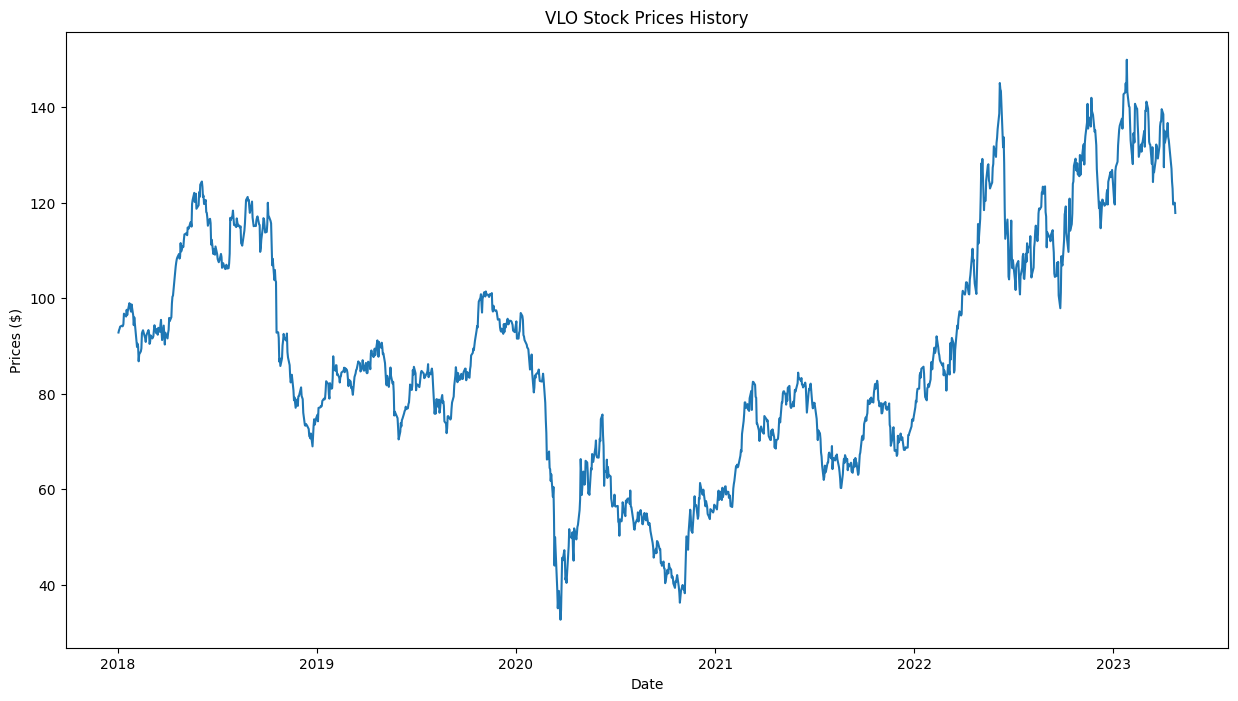

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(15, 8))
plt.title('VLO Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

**DATA PREPROCESSING**



*   Normalize data using the MinMaxScaler method




In [ ]:
close_prices = data['Close']
values = close_prices.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))



*   Split data into train, test, and validation sets with a ratio of 7:2:1




In [ ]:
train_size = int(len(scaled_data) * 0.7)
test_size = int(len(scaled_data) * 0.2)
val_size = len(scaled_data) - train_size - test_size

time_step = 60
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-time_step:train_size+test_size, :]
val_data = scaled_data[train_size+test_size-time_step:, :]

In [ ]:
print("Dataset size: ", len(values), "\n")

print("Train size: ", train_size)
print("Test size: ", test_size)
print("Valate size: ", val_size)

Dataset size:  1337 

Train size:  935
Test size:  267
Valate size:  135




*   Define the Create Dataset function


In [ ]:
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----59   Y=60
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)



*   Create train, test, and validation datasets



In [ ]:
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)



*   Reshape train, test, and validation data (required for LSTM)



In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

**BUILD LSTM MODEL**



*   Import Packages


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 126,301
Trainable params: 126,301
Non-trainable params: 0
_________________________________________________________________


*This LSTM model has two LSTM layers with 100 units each, connected to two Dense layers with 50 and 1 unit, respectively.*

**TRAIN THE MODEL**



*   Fit the model with the train data



In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
28/28 [==============================] - 18s 261ms/step - loss: 0.0214
Epoch 2/50
28/28 [==============================] - 6s 215ms/step - loss: 0.0022
Epoch 3/50
28/28 [==============================] - 6s 210ms/step - loss: 0.0015
Epoch 4/50
28/28 [==============================] - 5s 171ms/step - loss: 0.0015
Epoch 5/50
28/28 [==============================] - 3s 98ms/step - loss: 0.0014
Epoch 6/50
28/28 [==============================] - 3s 98ms/step - loss: 0.0013
Epoch 7/50
28/28 [==============================] - 3s 106ms/step - loss: 0.0012
Epoch 8/50
28/28 [==============================] - 4s 156ms/step - loss: 0.0010
Epoch 9/50
28/28 [==============================] - 3s 98ms/step - loss: 9.7736e-04
Epoch 10/50
28/28 [==============================] - 3s 99ms/step - loss: 9.6873e-04
Epoch 11/50
28/28 [==============================] - 3s 98ms/step - loss: 9.4934e-04
Epoch 12/50
28/28 [==============================] - 4s 133ms/step - loss: 9.5472e-04
Epoch 13/50
2



*   PLotting loss, it shows that loss has decreased significantly and model trained well



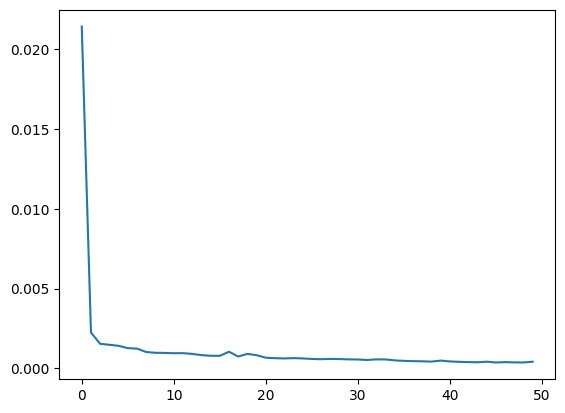

In [ ]:
loss = model.history.history['loss']
plt.plot(loss)

**PREDICTION AND EVALUATION ON TEST DATA**



*   Make predictions on test and validation data



In [ ]:
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 26ms/step




*   Convert the predictions back to the original values



In [ ]:
y_pred=scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_val=scaler.inverse_transform(y_pred_val)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))



*   Evaluate the algorithm's accuracy using RMSE, MAPE, MDA



In [ ]:
# MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Using RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_val - y_pred_val) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)

valid_mda = calculate_mda(np.squeeze(y_val), np.squeeze(y_pred_val)) # Squeeze y_val and y_pred_val to 1D arrays
test_mda = calculate_mda(np.squeeze(y_test), np.squeeze(y_pred)) # Squeeze y_test and y_pred to 1D arrays

# Print results
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 3.368149669310285
Testing RMSE: 3.051048278266371
Validation MAPE: 2.0487630407149453
Testing MAPE: 2.3199396448198515
Validation MDA: 52.98507462686567
Testing MDA: 53.00751879699248


In [ ]:
np.squeeze(y_val)

array([109.690002, 115.199997, 120.860001, 114.120003, 115.5     ,
       117.699997, 123.959999, 124.440002, 127.739998, 129.220001,
       126.800003, 126.739998, 128.270004, 125.980003, 125.550003,
       130.      , 125.830002, 129.710007, 128.720001, 131.779999,
       132.25    , 128.      , 132.449997, 133.960007, 136.800003,
       140.710007, 135.529999, 137.910004, 137.619995, 135.960007,
       141.979996, 139.210007, 138.399994, 134.839996, 135.199997,
       133.619995, 132.029999, 127.07    , 120.959999, 118.860001,
       120.190002, 116.900002, 114.650002, 120.660004, 120.529999,
       119.730003, 119.919998, 119.370003, 119.709999, 121.879997,
       122.68    , 119.620003, 124.370003, 126.410004, 125.349998,
       126.32    , 126.860001, 120.040001, 119.620003, 126.589996,
       127.559998, 128.580002, 132.009995, 133.600006, 135.320007,
       136.130005, 137.610001, 135.520004, 138.470001, 142.729996,
       143.080002, 145.029999, 143.350006, 149.960007, 143.210

**FORECAST FOR THE NEXT 30 DAYS IN THE FUTURE**

In [ ]:
n_days = 30

x_input=scaled_data[-time_step:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<n_days):

    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, time_step,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.7230809]
61
1 day input [0.91537406 0.88298952 0.85588885 0.84463943 0.81361846 0.86841655
 0.86500758 0.85222421 0.92133961 0.91341398 0.91247653 0.88418262
 0.86372929 0.82657231 0.84864489 0.83577634 0.85060497 0.85333215
 0.87293333 0.84463943 0.90906755 0.90855624 0.92508941 0.91247653
 0.88921085 0.85350263 0.84932668 0.84830406 0.81378895 0.84370197
 0.78157488 0.80577802 0.79896027 0.82060677 0.84855971 0.84498038
 0.83313448 0.82358948 0.84591784 0.88119991 0.88912554 0.88972216
 0.91170956 0.9025907  0.80799382 0.87327416 0.85196855 0.87335947
 0.88708029 0.86159873 0.85657064 0.84574736 0.81540819 0.80526671
 0.78217144 0.76981415 0.7415203  0.74467356 0.72635072 0.72308087]
1 day output [[0.7173258]]
2 day input [0.88298952 0.85588885 0.84463943 0.81361846 0.86841655 0.86500758
 0.85222421 0.92133961 0.91341398 0.91247653 0.88418262 0.86372929
 0.82657231 0.84864489 0.83577634 0.85060497 0.85333215 0.87293333
 0.84463943 0.90906755 0.90855624 0.92508941 0.91247653 0.8892



*   List of predicted stock prices for the next 30 days



In [ ]:
for i in range(1, n_days+1):
    print(f"Ngày thứ {i}: {scaler.inverse_transform(lst_output)[i-1]}")
    # scaler.inverse_transform(lst_output)

Ngày thứ 1: [117.46631448]
Ngày thứ 2: [116.79101489]
Ngày thứ 3: [116.20139191]
Ngày thứ 4: [115.60769143]
Ngày thứ 5: [114.96980978]
Ngày thứ 6: [114.26684888]
Ngày thứ 7: [113.49474521]
Ngày thứ 8: [112.66229721]
Ngày thứ 9: [111.78637446]
Ngày thứ 10: [110.88744841]
Ngày thứ 11: [109.98575972]
Ngày thứ 12: [109.09866753]
Ngày thứ 13: [108.23908978]
Ngày thứ 14: [107.41499263]
Ngày thứ 15: [106.62958635]
Ngày thứ 16: [105.88222748]
Ngày thứ 17: [105.16950993]
Ngày thứ 18: [104.48640502]
Ngày thứ 19: [103.82726859]
Ngày thứ 20: [103.18674321]
Ngày thứ 21: [102.56025481]
Ngày thứ 22: [101.94437632]
Ngày thứ 23: [101.33677175]
Ngày thứ 24: [100.73630106]
Ngày thứ 25: [100.14266352]
Ngày thứ 26: [99.5562438]
Ngày thứ 27: [98.97773431]
Ngày thứ 28: [98.40798131]
Ngày thứ 29: [97.84778913]
Ngày thứ 30: [97.2978012]


**VISUALIZATION OF PREDICTIONS**



*   Plot 1



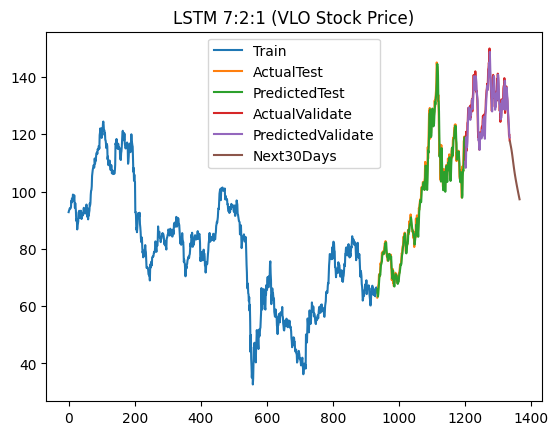

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.title('LSTM 7:2:1 (VLO Stock Price)')
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_test)
plt.plot(test_data_index,y_pred)
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_val)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(close_prices), stop=len(close_prices)+n_days, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate','Next30Days'])
plt.show()



*   Plot 2



In [ ]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_test[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualTest', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedTest', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_val[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualValidate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedValidate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'LSTM 7:2:1 (VLO Stock Price)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()



*   Plot 3



In [ ]:
prediect_index = pd.RangeIndex(start=1, stop=1+n_days, step=1)

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=prediect_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#FF7F0E'))
for i in range(len(prediect_index)):
  fig2.add_annotation(
      x=prediect_index[i],
      y=scaler.inverse_transform(lst_output)[i, 0],
      text=f"{scaler.inverse_transform(lst_output)[i, 0]:.2f}",
      showarrow=False,
      font=dict(color='black'),
      align='center',
      yshift=10)

fig2.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'LSTM Prediction 7:2:1 (VLO Stock Price)', title_x = 0.5,
                  xaxis_title="Day",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig2.show()